# ETA Agent Performance Analysis

Analysis of ETA agent performance logs from time.txt and time6.txt files.

## Data Overview
- **time.txt**: 16,529 records (07/11/2025)
- **time6.txt**: 141,657 records (06/11/2025)

## Analysis Goals
1. Performance Statistics (min/max/avg/std dev)
2. Time Pattern Analysis 
3. Process Performance Comparison
4. Outlier Detection
5. Trend Analysis (day-over-day)
6. Statistical Insights

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
from scipy import stats

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## Data Loading and Preprocessing

In [2]:
def parse_log_file(filepath):
    """
    Parse ETA agent log file and extract structured data
    Format: eta_agent.PID:DATE TIME TRANSACTION_ID TOOK Xs
    """
    data = []
    
    with open(filepath, 'r') as file:
        for line in file:
            line = line.strip()
            if not line:
                continue
                
            # Extract components using regex
            pattern = r'(eta_\w+)\.(\d+):([\d/]+) ([\d:.]+) (\d+) TOOK ([\d.]+)s'
            match = re.match(pattern, line)
            
            if match:
                agent_type, pid, date, time, transaction_id, execution_time = match.groups()
                
                # Parse datetime
                datetime_str = f"{date} {time}"
                dt = datetime.strptime(datetime_str, "%d/%m/%Y %H:%M:%S.%f")
                
                data.append({
                    'agent_type': agent_type,
                    'pid': int(pid),
                    'datetime': dt,
                    'date': dt.date(),
                    'time': dt.time(),
                    'hour': dt.hour,
                    'transaction_id': int(transaction_id),
                    'execution_time': float(execution_time)
                })
    
    return pd.DataFrame(data)

print("Log parser function defined!")

Log parser function defined!


In [3]:
# Load both datasets
print("Loading time.txt (today)...")
df_today = parse_log_file('time.txt')
print(f"Loaded {len(df_today)} records")

print("\nLoading time6.txt (yesterday)...")
df_yesterday = parse_log_file('time6.txt')
print(f"Loaded {len(df_yesterday)} records")

# Add day labels
df_today['day'] = 'Today (07/11)'
df_yesterday['day'] = 'Yesterday (06/11)'

# Combine datasets for comparison
df_combined = pd.concat([df_today, df_yesterday], ignore_index=True)

print(f"\nTotal combined records: {len(df_combined)}")
print("\nDataset preview:")
df_today.head()

Loading time.txt (today)...
Loaded 16529 records

Loading time6.txt (yesterday)...
Loaded 141657 records

Total combined records: 158186

Dataset preview:


,agent_type,pid,datetime,date,time,hour,transaction_id,execution_time,day
0,eta_agent,7690,2025-11-07 00:00:04.135,2025-11-07,00:00:04.135000,0,11017739711402,13.047,Today (07/11)
1,eta_agent,7690,2025-11-07 00:00:18.813,2025-11-07,00:00:18.813000,0,11017739697326,4.913,Today (07/11)
2,eta_agent,7690,2025-11-07 00:01:16.063,2025-11-07,00:01:16.063000,0,11017739697649,18.119,Today (07/11)
3,eta_agent,7690,2025-11-07 00:01:23.912,2025-11-07,00:01:23.912000,0,11017739712235,0.047,Today (07/11)
4,eta_agent,7690,2025-11-07 00:01:47.073,2025-11-07,00:01:47.073000,0,11017739712297,14.945,Today (07/11)


## 1. Performance Statistics & Standard Deviation Analysis

In [4]:
def calculate_statistics(df, label=""):
    """
    Calculate comprehensive performance statistics
    """
    exec_times = df['execution_time']
    
    stats_dict = {
        'Count': len(exec_times),
        'Mean': exec_times.mean(),
        'Median': exec_times.median(),
        'Std Dev': exec_times.std(),
        'Min': exec_times.min(),
        'Max': exec_times.max(),
        'P25': exec_times.quantile(0.25),
        'P75': exec_times.quantile(0.75),
        'P95': exec_times.quantile(0.95),
        'P99': exec_times.quantile(0.99),
        'CV (%)': (exec_times.std() / exec_times.mean()) * 100,
        'Skewness': stats.skew(exec_times),
        'Kurtosis': stats.kurtosis(exec_times)
    }
    
    return pd.Series(stats_dict, name=label)

# Calculate statistics for both days
stats_today = calculate_statistics(df_today, "Today")
stats_yesterday = calculate_statistics(df_yesterday, "Yesterday")

# Create comparison table
stats_comparison = pd.DataFrame([stats_today, stats_yesterday]).round(3)

print("📊 PERFORMANCE STATISTICS COMPARISON")
print("=" * 50)
print(stats_comparison)

# Key insights
print("\n🔍 KEY INSIGHTS:")
print(f"• CV 7-Nov: {stats_today['CV (%)']:.1f}% vs 6-Nov: {stats_yesterday['CV (%)']:.1f}%")
print(f"• P95 7-Nov: {stats_today['P95']:.2f}s vs 6-Nov: {stats_yesterday['P95']:.2f}s")
print(f"• Mean Performance: {stats_today['Mean']:.2f}s vs {stats_yesterday['Mean']:.2f}s")

📊 PERFORMANCE STATISTICS COMPARISON
              Count   Mean  Median  Std Dev    Min      Max    P25    P75  \
Today       16529.0  5.610   1.670    7.977  0.021   94.825  0.605  8.769   
Yesterday  141657.0  3.468   1.646    5.683  0.019  119.153  0.687  3.848   

              P95     P99   CV (%)  Skewness  Kurtosis  
Today      19.268  36.666  142.178     3.062    16.256  
Yesterday  13.338  23.423  163.856     5.739    59.034  

🔍 KEY INSIGHTS:
• CV 7-Nov: 142.2% vs 6-Nov: 163.9%
• P95 7-Nov: 19.27s vs 6-Nov: 13.34s
• Mean Performance: 5.61s vs 3.47s


## 2. Visual Performance Distribution Analysis

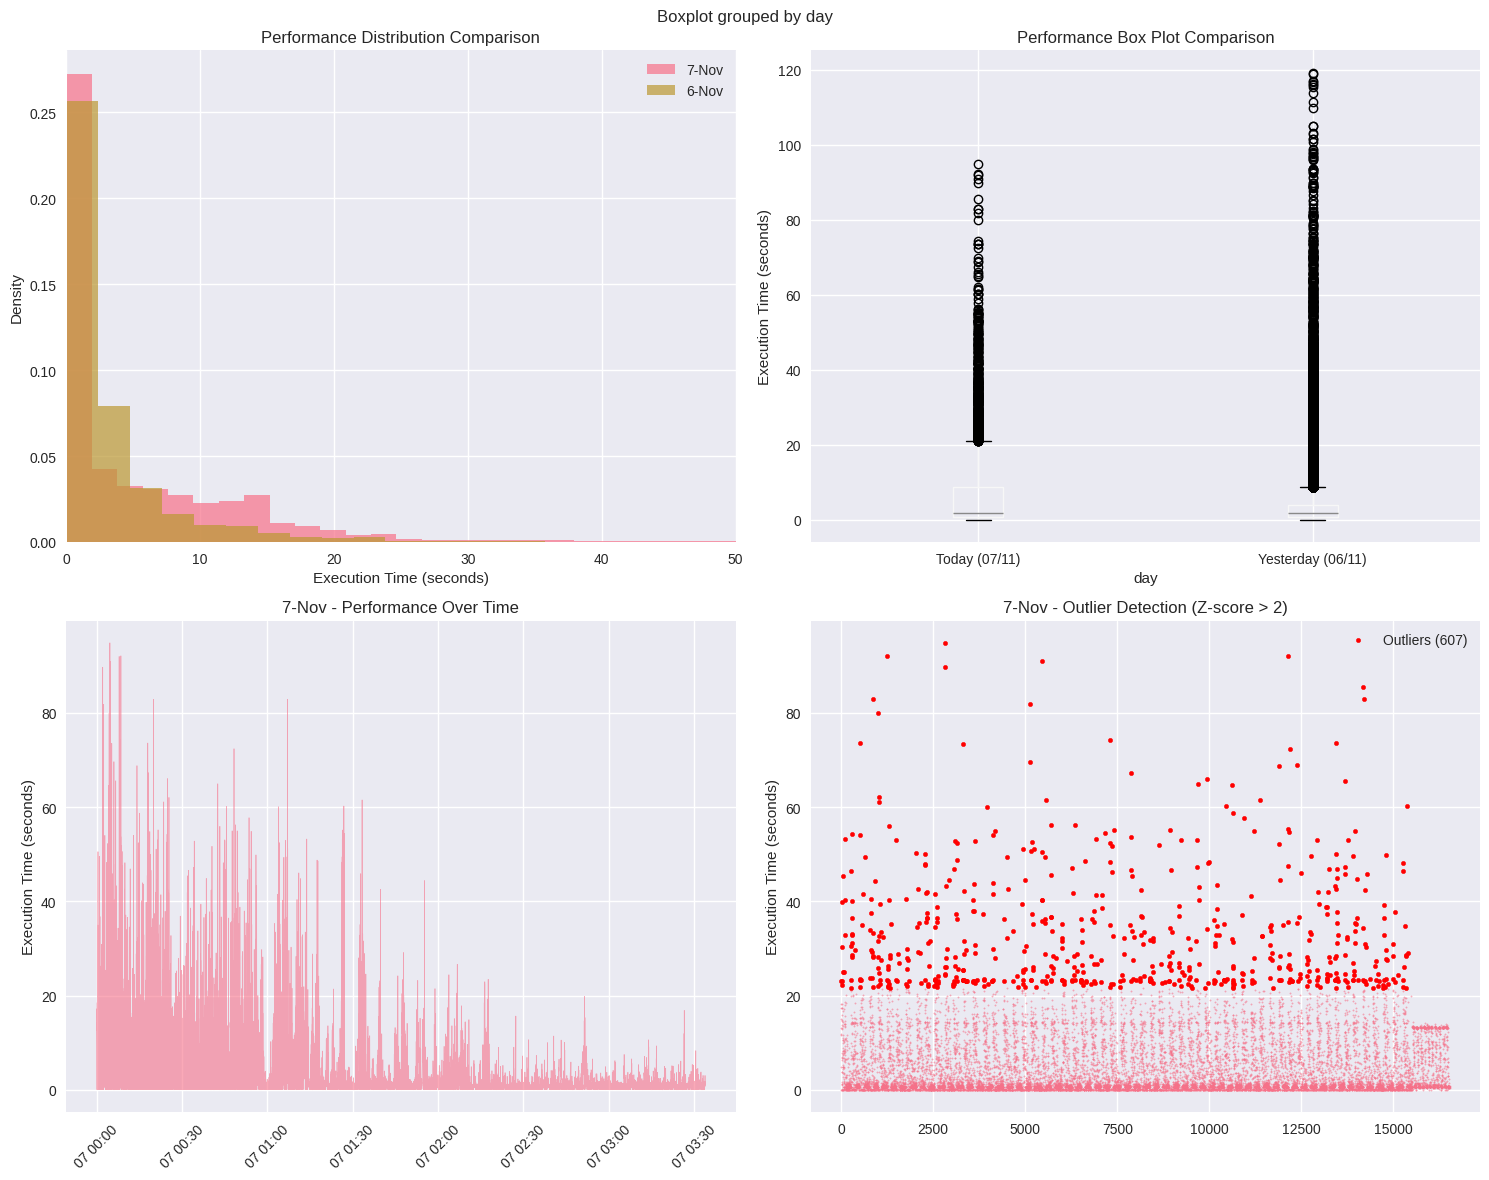

📍 Outliers detected today: 607 (3.7%)


In [5]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Distribution comparison
axes[0,0].hist(df_today['execution_time'], bins=50, alpha=0.7, label='7-Nov', density=True)
axes[0,0].hist(df_yesterday['execution_time'], bins=50, alpha=0.7, label='6-Nov', density=True)
axes[0,0].set_xlabel('Execution Time (seconds)')
axes[0,0].set_ylabel('Density')
axes[0,0].set_title('Performance Distribution Comparison')
axes[0,0].legend()
axes[0,0].set_xlim(0, 50)  # Focus on main distribution

# 2. Box plot comparison
df_combined.boxplot(column='execution_time', by='day', ax=axes[0,1])
axes[0,1].set_title('Performance Box Plot Comparison')
axes[0,1].set_ylabel('Execution Time (seconds)')

# 3. Time series - Today
df_today_sorted = df_today.sort_values('datetime')
axes[1,0].plot(df_today_sorted['datetime'], df_today_sorted['execution_time'], alpha=0.6, linewidth=0.5)
axes[1,0].set_title('7-Nov - Performance Over Time')
axes[1,0].set_ylabel('Execution Time (seconds)')
axes[1,0].tick_params(axis='x', rotation=45)

# 4. Outlier analysis (Z-score)
z_scores_today = np.abs(stats.zscore(df_today['execution_time']))
outliers_today = df_today[z_scores_today > 2]

axes[1,1].scatter(range(len(df_today)), df_today['execution_time'], alpha=0.5, s=1)
axes[1,1].scatter(outliers_today.index, outliers_today['execution_time'], color='red', s=10, label=f'Outliers ({len(outliers_today)})')
axes[1,1].set_title('7-Nov - Outlier Detection (Z-score > 2)')
axes[1,1].set_ylabel('Execution Time (seconds)')
axes[1,1].legend()

plt.tight_layout()
plt.show()

print(f"📍 Outliers detected today: {len(outliers_today)} ({len(outliers_today)/len(df_today)*100:.1f}%)")

## 3. Hourly Performance Patterns

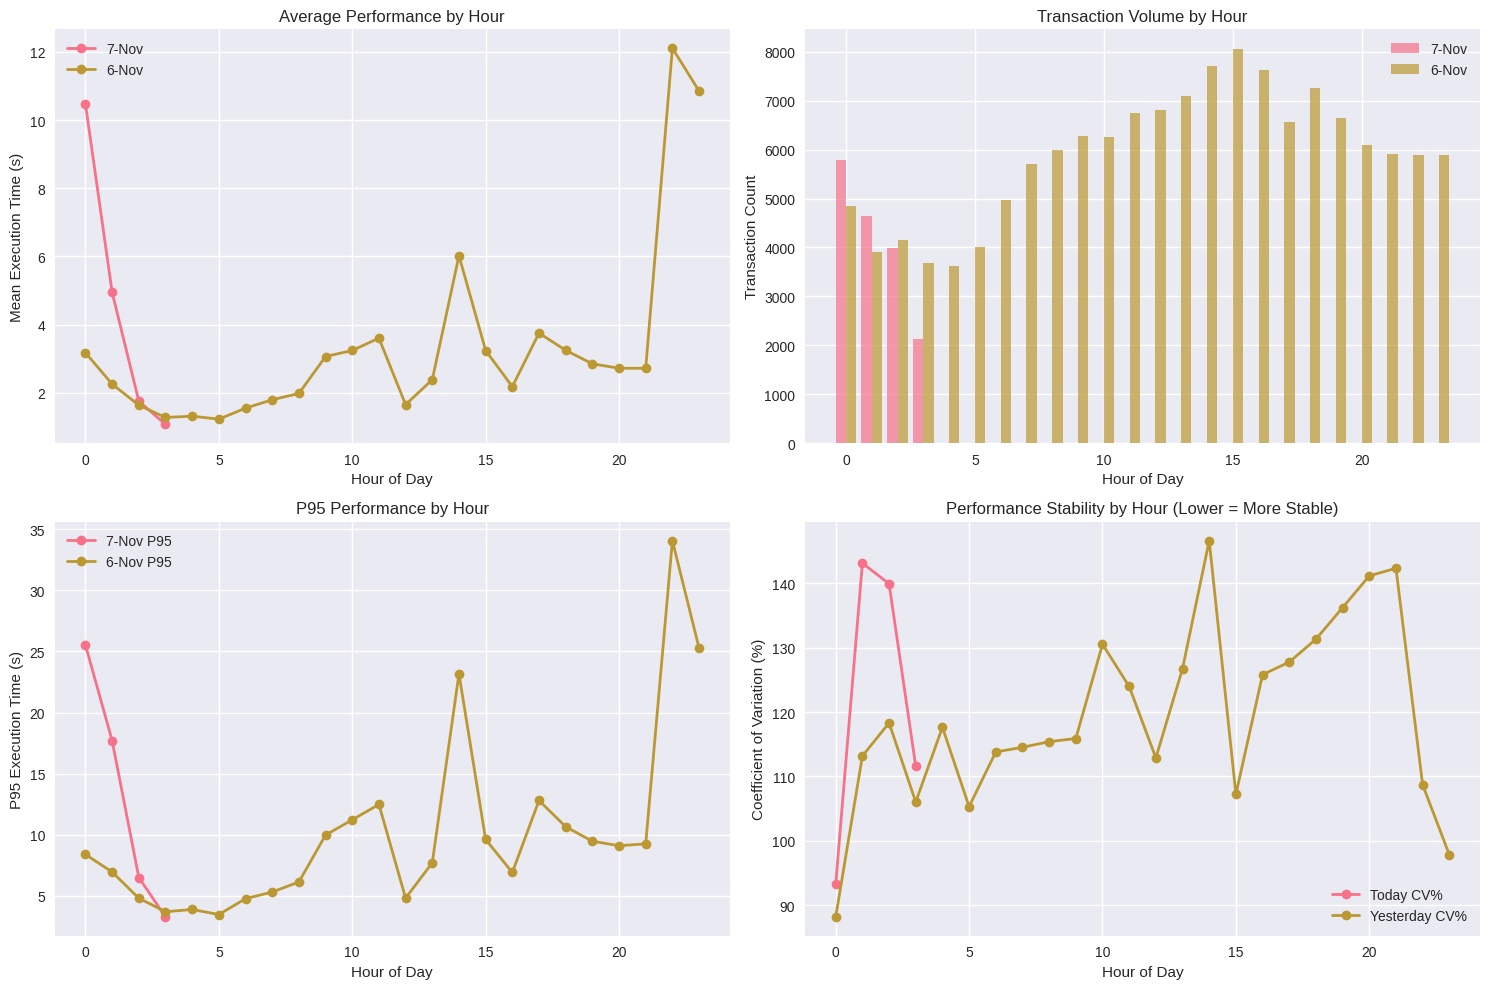


📊 HOURLY ANALYSIS SUMMARY:
Peak volume today: Hour 0 (5777 transactions)
Best performance today: Hour 3 (1.07s avg)
Most stable hour today: Hour 0 (93.2% CV)


In [6]:
# Hourly analysis
hourly_stats_today = df_today.groupby('hour')['execution_time'].agg([
    'count', 'mean', 'std', 'min', 'max', 
    lambda x: x.quantile(0.95)
]).round(3)
hourly_stats_today.columns = ['Count', 'Mean', 'Std Dev', 'Min', 'Max', 'P95']

hourly_stats_yesterday = df_yesterday.groupby('hour')['execution_time'].agg([
    'count', 'mean', 'std', 'min', 'max',
    lambda x: x.quantile(0.95)
]).round(3)
hourly_stats_yesterday.columns = ['Count', 'Mean', 'Std Dev', 'Min', 'Max', 'P95']

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Mean performance by hour
axes[0,0].plot(hourly_stats_today.index, hourly_stats_today['Mean'], 'o-', label='7-Nov', linewidth=2)
axes[0,0].plot(hourly_stats_yesterday.index, hourly_stats_yesterday['Mean'], 'o-', label='6-Nov', linewidth=2)
axes[0,0].set_xlabel('Hour of Day')
axes[0,0].set_ylabel('Mean Execution Time (s)')
axes[0,0].set_title('Average Performance by Hour')
axes[0,0].legend()
axes[0,0].grid(True)

# Transaction volume by hour
axes[0,1].bar(hourly_stats_today.index - 0.2, hourly_stats_today['Count'], 0.4, label='7-Nov', alpha=0.7)
axes[0,1].bar(hourly_stats_yesterday.index + 0.2, hourly_stats_yesterday['Count'], 0.4, label='6-Nov', alpha=0.7)
axes[0,1].set_xlabel('Hour of Day')
axes[0,1].set_ylabel('Transaction Count')
axes[0,1].set_title('Transaction Volume by Hour')
axes[0,1].legend()

# P95 performance by hour
axes[1,0].plot(hourly_stats_today.index, hourly_stats_today['P95'], 'o-', label='7-Nov P95', linewidth=2)
axes[1,0].plot(hourly_stats_yesterday.index, hourly_stats_yesterday['P95'], 'o-', label='6-Nov P95', linewidth=2)
axes[1,0].set_xlabel('Hour of Day')
axes[1,0].set_ylabel('P95 Execution Time (s)')
axes[1,0].set_title('P95 Performance by Hour')
axes[1,0].legend()
axes[1,0].grid(True)

# Coefficient of Variation by hour
cv_today = (hourly_stats_today['Std Dev'] / hourly_stats_today['Mean']) * 100
cv_yesterday = (hourly_stats_yesterday['Std Dev'] / hourly_stats_yesterday['Mean']) * 100

axes[1,1].plot(hourly_stats_today.index, cv_today, 'o-', label='Today CV%', linewidth=2)
axes[1,1].plot(hourly_stats_yesterday.index, cv_yesterday, 'o-', label='Yesterday CV%', linewidth=2)
axes[1,1].set_xlabel('Hour of Day')
axes[1,1].set_ylabel('Coefficient of Variation (%)')
axes[1,1].set_title('Performance Stability by Hour (Lower = More Stable)')
axes[1,1].legend()
axes[1,1].grid(True)

plt.tight_layout()
plt.show()

print("\n📊 HOURLY ANALYSIS SUMMARY:")
print(f"Peak volume today: Hour {hourly_stats_today['Count'].idxmax()} ({hourly_stats_today['Count'].max()} transactions)")
print(f"Best performance today: Hour {hourly_stats_today['Mean'].idxmin()} ({hourly_stats_today['Mean'].min():.2f}s avg)")
print(f"Most stable hour today: Hour {cv_today.idxmin()} ({cv_today.min():.1f}% CV)")

## 4. Process Analysis (PID Performance)

📈 PROCESS ANALYSIS - Today (70 active PIDs with 10+ transactions)
      Count   Mean  Std Dev    Min     Max
pid                                       
7696    268  4.481    6.227  0.028  52.908
8110    286  4.574    6.064  0.024  27.415
7760    288  4.629    6.382  0.024  40.385
7853    273  4.679    6.135  0.027  32.215
7769    300  4.723    7.733  0.025  54.840
7771    246  4.924    6.015  0.033  33.784
7788    301  5.087    7.597  0.025  56.262
8023    255  5.095    7.099  0.036  57.727
7861    276  5.141    7.074  0.032  42.485
8144    272  5.163    6.587  0.026  37.677

🎯 Best performing PID: 7696 (avg: 4.481s)
🐌 Slowest PID: 8143 (avg: 6.675s)


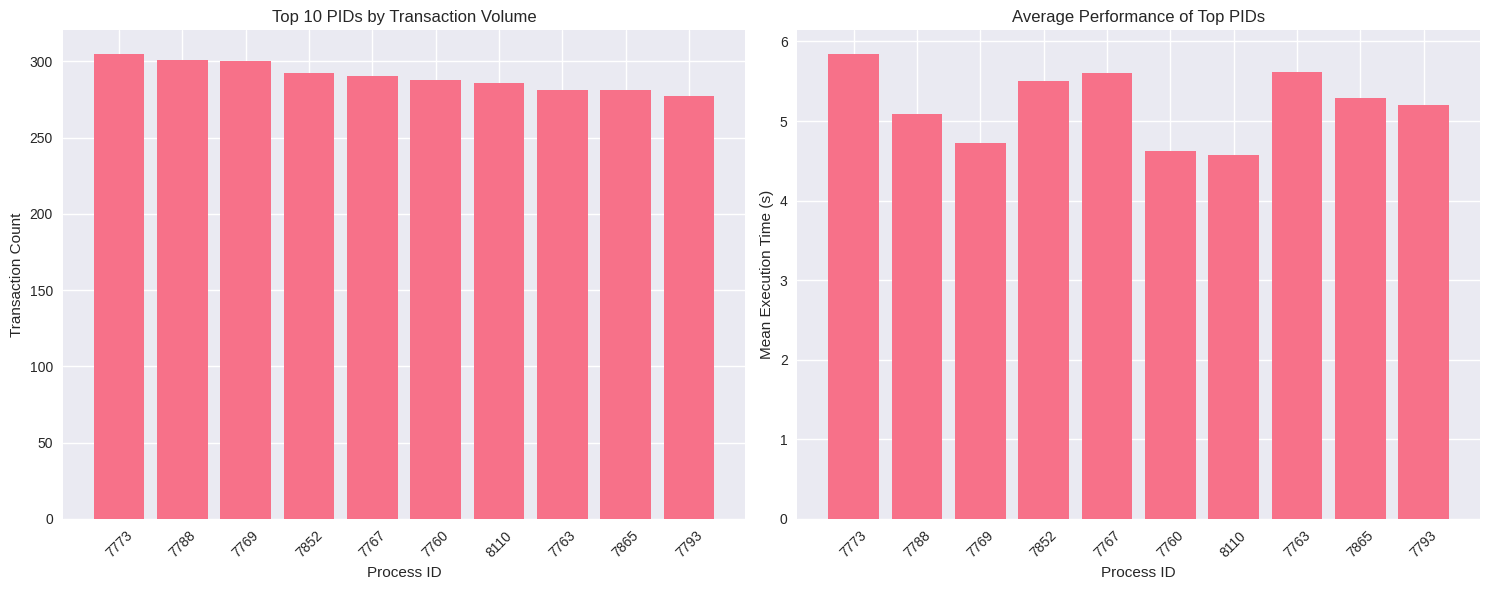

In [7]:
# Analyze performance by process ID
pid_stats_today = df_today.groupby('pid')['execution_time'].agg([
    'count', 'mean', 'std', 'min', 'max'
]).round(3)
pid_stats_today.columns = ['Count', 'Mean', 'Std Dev', 'Min', 'Max']
pid_stats_today = pid_stats_today[pid_stats_today['Count'] >= 10]  # Filter PIDs with significant activity

print(f"📈 PROCESS ANALYSIS - Today ({len(pid_stats_today)} active PIDs with 10+ transactions)")
print("=" * 70)
print(pid_stats_today.sort_values('Mean').head(10))

# Top and bottom performers
best_pid = pid_stats_today['Mean'].idxmin()
worst_pid = pid_stats_today['Mean'].idxmax()

print(f"\n🎯 Best performing PID: {best_pid} (avg: {pid_stats_today.loc[best_pid, 'Mean']:.3f}s)")
print(f"🐌 Slowest PID: {worst_pid} (avg: {pid_stats_today.loc[worst_pid, 'Mean']:.3f}s)")

# Visualize top 10 PIDs by transaction count
top_pids = pid_stats_today.nlargest(10, 'Count')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Transaction count
ax1.bar(range(len(top_pids)), top_pids['Count'])
ax1.set_xticks(range(len(top_pids)))
ax1.set_xticklabels([str(pid) for pid in top_pids.index], rotation=45)
ax1.set_xlabel('Process ID')
ax1.set_ylabel('Transaction Count')
ax1.set_title('Top 10 PIDs by Transaction Volume')

# Average performance
ax2.bar(range(len(top_pids)), top_pids['Mean'])
ax2.set_xticks(range(len(top_pids)))
ax2.set_xticklabels([str(pid) for pid in top_pids.index], rotation=45)
ax2.set_xlabel('Process ID')
ax2.set_ylabel('Mean Execution Time (s)')
ax2.set_title('Average Performance of Top PIDs')

plt.tight_layout()
plt.show()

## 5. Advanced Statistical Analysis & Anomaly Detection

In [8]:
# Advanced anomaly detection using multiple methods
def detect_anomalies(df, method='zscore', threshold=2):
    """
    Detect anomalies using various statistical methods
    """
    exec_times = df['execution_time'].values
    
    if method == 'zscore':
        z_scores = np.abs(stats.zscore(exec_times))
        anomalies = df[z_scores > threshold]
    elif method == 'iqr':
        Q1 = df['execution_time'].quantile(0.25)
        Q3 = df['execution_time'].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        anomalies = df[(df['execution_time'] < lower_bound) | (df['execution_time'] > upper_bound)]
    elif method == 'percentile':
        p99 = df['execution_time'].quantile(0.99)
        anomalies = df[df['execution_time'] > p99]
    
    return anomalies

# Detect anomalies using different methods
anomalies_zscore = detect_anomalies(df_today, 'zscore', 2)
anomalies_iqr = detect_anomalies(df_today, 'iqr')
anomalies_p99 = detect_anomalies(df_today, 'percentile')

print("🚨 ANOMALY DETECTION RESULTS - Today")
print("=" * 40)
print(f"Z-Score (>2σ): {len(anomalies_zscore)} anomalies ({len(anomalies_zscore)/len(df_today)*100:.1f}%)")
print(f"IQR Method: {len(anomalies_iqr)} anomalies ({len(anomalies_iqr)/len(df_today)*100:.1f}%)")
print(f"P99 Method: {len(anomalies_p99)} anomalies ({len(anomalies_p99)/len(df_today)*100:.1f}%)")

# Show worst performing transactions
worst_transactions = df_today.nlargest(30, 'execution_time')[['datetime', 'pid', 'execution_time', 'transaction_id']]
print("\n⚠️ TOP 30 SLOWEST TRANSACTIONS:")
print(worst_transactions)

# Statistical tests
# Normality test
shapiro_stat, shapiro_p = stats.shapiro(df_today['execution_time'].sample(5000))  # Sample for large dataset
print(f"\n📊 STATISTICAL TESTS:")
print(f"Shapiro-Wilk (Normality): p-value = {shapiro_p:.2e} {'(Normal)' if shapiro_p > 0.05 else '(Not Normal)'}")

# Compare today vs yesterday (t-test)
t_stat, t_p = stats.ttest_ind(df_today['execution_time'], df_yesterday['execution_time'].sample(len(df_today)))
print(f"T-test (Today vs Yesterday): p-value = {t_p:.2e} {'(No significant difference)' if t_p > 0.05 else '(Significant difference)'}")

🚨 ANOMALY DETECTION RESULTS - Today
Z-Score (>2σ): 607 anomalies (3.7%)
IQR Method: 640 anomalies (3.9%)
P99 Method: 166 anomalies (1.0%)

⚠️ TOP 30 SLOWEST TRANSACTIONS:
                     datetime   pid  execution_time  transaction_id
2813  2025-11-07 00:04:38.432  7764          94.825  11017739713079
1252  2025-11-07 00:08:30.616  7695          92.071  11017739715152
12146 2025-11-07 00:07:54.512  8079          91.945  11017739714817
5447  2025-11-07 00:04:53.681  7785          90.879  11017739713235
2810  2025-11-07 00:02:06.944  7764          89.643  11017739701676
14173 2025-11-07 00:02:07.882  8109          85.365  11017739711866
863   2025-11-07 01:07:04.913  7693          82.861  11017739800794
14195 2025-11-07 00:19:58.350  8109          82.832  11017739724320
5138  2025-11-07 00:02:27.541  7773          81.791  11017739712070
1003  2025-11-07 00:04:23.498  7694          79.891  11017739702355
7301  2025-11-07 00:08:18.014  7852          74.297  11017739715200
13439 2025-11

## 6. Summary Report & Recommendations

In [9]:
# Generate comprehensive summary report
print("📋 ETA AGENT PERFORMANCE SUMMARY REPORT")
print("=" * 60)
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Period: Yesterday ({df_yesterday['date'].iloc[0]}) vs Today ({df_today['date'].iloc[0]})")

print("\n📈 KEY PERFORMANCE INDICATORS:")
print(f"• Average Response Time: {stats_today['Mean']:.2f}s (vs {stats_yesterday['Mean']:.2f}s yesterday)")
print(f"• P95 Response Time: {stats_today['P95']:.2f}s (vs {stats_yesterday['P95']:.2f}s yesterday)")
print(f"• Performance Stability (CV): {stats_today['CV (%)']:.1f}% (vs {stats_yesterday['CV (%)']:.1f}% yesterday)")
print(f"• Transaction Volume: {len(df_today):,} (vs {len(df_yesterday):,} yesterday)")

# Performance trend
perf_change = ((stats_today['Mean'] - stats_yesterday['Mean']) / stats_yesterday['Mean']) * 100
vol_change = ((len(df_today) - len(df_yesterday)) / len(df_yesterday)) * 100

print("\n📊 PERFORMANCE TRENDS:")
print(f"• Performance Change: {perf_change:+.1f}% {'⬆️' if perf_change > 0 else '⬇️'}")
print(f"• Volume Change: {vol_change:+.1f}% {'⬆️' if vol_change > 0 else '⬇️'}")
print(f"• Stability Change: {stats_today['CV (%)'] - stats_yesterday['CV (%)']:+.1f}% CV {'📈' if stats_today['CV (%)'] > stats_yesterday['CV (%)'] else '📉'}")

print("\n🎯 RECOMMENDATIONS:")
if stats_today['CV (%)'] > 50:
    print("• HIGH VARIABILITY DETECTED: Investigate performance inconsistencies")
if stats_today['P95'] > 30:
    print("• SLOW TAIL LATENCY: 5% of transactions exceed 30s - investigate bottlenecks")
if len(anomalies_zscore) / len(df_today) > 0.02:
    print("• ANOMALY ALERT: High number of outliers detected - check system health")
if perf_change > 10:
    print("• PERFORMANCE DEGRADATION: Average response time increased significantly")
elif perf_change < -10:
    print("• PERFORMANCE IMPROVEMENT: Average response time decreased significantly")

# Find peak hours for capacity planning
peak_hour = hourly_stats_today['Count'].idxmax()
low_hour = hourly_stats_today['Count'].idxmin()

print("\n⏰ CAPACITY PLANNING:")
print(f"• Peak Hour: {peak_hour}:00 ({hourly_stats_today.loc[peak_hour, 'Count']} transactions)")
print(f"• Low Hour: {low_hour}:00 ({hourly_stats_today.loc[low_hour, 'Count']} transactions)")
print(f"• Peak/Low Ratio: {hourly_stats_today.loc[peak_hour, 'Count'] / hourly_stats_today.loc[low_hour, 'Count']:.1f}x")

print("\n" + "=" * 60)
print("Analysis Complete! 📊✅")

📋 ETA AGENT PERFORMANCE SUMMARY REPORT
Analysis Date: 2025-11-10 12:12:59
Period: Yesterday (2025-11-06) vs Today (2025-11-07)

📈 KEY PERFORMANCE INDICATORS:
• Average Response Time: 5.61s (vs 3.47s yesterday)
• P95 Response Time: 19.27s (vs 13.34s yesterday)
• Performance Stability (CV): 142.2% (vs 163.9% yesterday)
• Transaction Volume: 16,529 (vs 141,657 yesterday)

📊 PERFORMANCE TRENDS:
• Performance Change: +61.8% ⬆️
• Volume Change: -88.3% ⬇️
• Stability Change: -21.7% CV 📉

🎯 RECOMMENDATIONS:
• HIGH VARIABILITY DETECTED: Investigate performance inconsistencies
• ANOMALY ALERT: High number of outliers detected - check system health
• PERFORMANCE DEGRADATION: Average response time increased significantly

⏰ CAPACITY PLANNING:
• Peak Hour: 0:00 (5777 transactions)
• Low Hour: 3:00 (2127 transactions)
• Peak/Low Ratio: 2.7x

Analysis Complete! 📊✅
